# Development of model for localization of axes and legend of line graphs

IMPORTARE IL DATASET CON LE ANNOTAZIONI

In [ ]:

!unzip ds.zip

!rm ds.zip

!mkdir output
!mkdir output/Plots

CONFIG FILE

In [ ]:
# import the necessary packages
import os

MAX_NUM_LINES = 10
# define the base path to the input dataset and then use it to derive
# the path to the images directory and annotation CSV file
BASE_PATH = "FigureSeerDataset"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "Annotated_images"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "annotations.csv"])

# define the path to the base output directory
BASE_OUTPUT = "output"
# define the path to the output serialized model, model training plot,
# and testing image filenames
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "Plots/"])
TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images.txt"])
TRAIN_FILENAMES = os.path.sep.join([BASE_OUTPUT, "train_images.txt"])

# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 500
BATCH_SIZE = 8

MODEL FILE

In [ ]:
!pip install tensorflow_addons

# Copyright 2019 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Implements GIoU loss."""

from typing import Optional

import tensorflow as tf
from typeguard import typechecked

from tensorflow_addons.utils.keras_utils import LossFunctionWrapper
from tensorflow_addons.utils.types import TensorLike


class EIoULoss(LossFunctionWrapper):

    @typechecked
    def __init__(
            self,
            mode: str = "eiou",
            reduction: str = tf.keras.losses.Reduction.AUTO,
            name: Optional[str] = "eiou_loss",
    ):
        super().__init__(eiou_loss, name=name, reduction=reduction, mode=mode)


def eiou_loss(y_true: TensorLike, y_pred: TensorLike, mode: str = "eiou") -> tf.Tensor:
    """Implements the GIoU loss function.

    GIoU loss was first introduced in the
    [Generalized Intersection over Union:
    A Metric and A Loss for Bounding Box Regression]
    (https://giou.stanford.edu/GIoU.pdf).
    GIoU is an enhancement for models which use IoU in object detection.

    Args:
        y_true: true targets tensor. The coordinates of the each bounding
            box in boxes are encoded as [y_min, x_min, y_max, x_max].
        y_pred: predictions tensor. The coordinates of the each bounding
            box in boxes are encoded as [y_min, x_min, y_max, x_max].
        mode: one of ['giou', 'iou'], decided to calculate GIoU or IoU loss.

    Returns:
        GIoU loss float `Tensor`.
    """
    if mode not in ["iou", "eiou"]:
        raise ValueError("Value of mode should be 'iou' or 'giou'")
    y_pred = tf.convert_to_tensor(y_pred)
    if not y_pred.dtype.is_floating:
        y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, y_pred.dtype)
    eiou = tf.squeeze(_calculate_eiou(y_pred, y_true, mode))

    return 1 - eiou


def _calculate_eiou(b1: TensorLike, b2: TensorLike, mode: str = "eiou") -> tf.Tensor:
    """
    Args:
        b1: bounding box. The coordinates of the each bounding box in boxes are
            encoded as [y_min, x_min, y_max, x_max].
        b2: the other bounding box. The coordinates of the each bounding box
            in boxes are encoded as [y_min, x_min, y_max, x_max].
        mode: one of ['giou', 'iou'], decided to calculate GIoU or IoU loss.

    Returns:
        GIoU loss float `Tensor`.
    """
    zero = tf.convert_to_tensor(0.0, b1.dtype)
    b1_ymin, b1_xmin, b1_ymax, b1_xmax = tf.unstack(b1, 4, axis=-1)
    b2_ymin, b2_xmin, b2_ymax, b2_xmax = tf.unstack(b2, 4, axis=-1)
    b1_width = tf.maximum(zero, b1_xmax - b1_xmin)
    b1_height = tf.maximum(zero, b1_ymax - b1_ymin)
    b2_width = tf.maximum(zero, b2_xmax - b2_xmin)
    b2_height = tf.maximum(zero, b2_ymax - b2_ymin)
    b1_area = b1_width * b1_height
    b2_area = b2_width * b2_height

    intersect_ymin = tf.maximum(b1_ymin, b2_ymin)
    intersect_xmin = tf.maximum(b1_xmin, b2_xmin)
    intersect_ymax = tf.minimum(b1_ymax, b2_ymax)
    intersect_xmax = tf.minimum(b1_xmax, b2_xmax)
    intersect_width = tf.maximum(zero, intersect_xmax - intersect_xmin)
    intersect_height = tf.maximum(zero, intersect_ymax - intersect_ymin)
    intersect_area = intersect_width * intersect_height

    union_area = b1_area + b2_area - intersect_area
    iou = tf.math.divide_no_nan(intersect_area, union_area)
    if mode == "iou":
        return iou

    enclose_ymin = tf.minimum(b1_ymin, b2_ymin)
    enclose_xmin = tf.minimum(b1_xmin, b2_xmin)
    enclose_ymax = tf.maximum(b1_ymax, b2_ymax)
    enclose_xmax = tf.maximum(b1_xmax, b2_xmax)
    enclose_width = tf.maximum(zero, enclose_xmax - enclose_xmin)
    enclose_height = tf.maximum(zero, enclose_ymax - enclose_ymin)

    b1_central_y = (b1_ymin + b1_height / 2)
    b1_central_x = (b1_xmin + b1_width / 2)
    b2_central_y = (b2_ymin + b2_height / 2)
    b2_central_x = (b2_xmin + b2_width / 2)

    central_width = (b1_central_x - b2_central_x)
    central_heigth = (b1_central_y - b2_central_y)

    central_distance = central_width * central_width + central_heigth * central_heigth

    enclose_diagonal = enclose_width * enclose_width + enclose_height * enclose_height

    width_diff = (b1_width - b2_width) * (b1_width - b2_width)

    heigth_diff = (b1_height - b2_height) * (b1_height - b2_height)

    eiou = iou - tf.math.divide_no_nan(central_distance, enclose_diagonal) \
           - tf.math.divide_no_nan(width_diff, enclose_width * enclose_width) \
           - tf.math.divide_no_nan(heigth_diff, enclose_height * enclose_height)

    return eiou

     |████████████████████████████████| 706kB 4.1MB/s 


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Flatten, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# from eiou_loss import EIoULoss
from tensorflow.keras.losses import MeanAbsoluteError, CategoricalCrossentropy, MeanSquaredLogarithmicError
from tensorflow.keras.metrics import Accuracy
# import config
from tensorflow.keras.utils import plot_model
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers



def get_model():
    # set the input size
    input_shape = Input(shape=(224, 224, 3))

    # load the ResNet50 network, ensuring the head FC layers are left off
    resnet = ResNet50(weights="imagenet", include_top=False, input_tensor=input_shape)
    print("STRUTTURA ResNet50")
    for layer in resnet.layers[:-20]:
        layer.trainable = False
    resnet.summary()

    x = resnet(input)
    # x = Conv2D(4096, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    # x = Dropout(0.2)(x)
    # x = GlobalAveragePooling2D()(x)
    # legend_output = Dropout(0.2)(x)
    # x = Dense(256)(x)
    x = AveragePooling2D(pool_size=(7, 7))(x)
    x = Flatten(name="flatten")(x)
    x = Dense(256, activation="relu")(x)


    # construct a fully-connected layer header to output the predicted
    # bounding box coordinates

    # legend_output = Flatten(input_shape=(7, 7, 512))(x)
    # legend_output = Dense(256, activation='relu')(legend_output)
    legend_output = Dropout(0.3)(x)
    legend_output = Dense(4, activation='sigmoid', name='legend_bbox')(legend_output)

    # axis_output = Flatten(input_shape=(7, 7, 512))(x)
    # axis_output = Dense(256, activation='relu')(axis_output)
    axis_output = Dropout(0.3)(x)
    axis_output = Dense(4, activation='sigmoid', name='axis_bbox')(axis_output)

    model = Model(input, [legend_output, axis_output])

    # initialize the optimizer, compile the model, and show the model
    # summary
    opt = Adam(learning_rate=INIT_LR)
    model.compile(loss=[EIoULoss(), EIoULoss()],
                  optimizer=opt, metrics=[['mae'], ['mae']])
    print("STRUTTURA MODELLO COMPLETO")
    model.summary()
    plot_model(model, to_file=BASE_OUTPUT + '/model.png', show_shapes=True)

    return model

TRAIN FILE

In [ ]:
def save_plot(plot_name, H, parameters, title, loss_plot=True):
    N = NUM_EPOCHS
    plt.style.use("ggplot")
    plt.figure()
    for parameter in parameters:
        plt.plot(np.arange(0, N), H.history[parameter], label=parameter)
    plt.title('\n'.join(wrap(title, 60)))
    plt.xlabel("Epoch #")
    if loss_plot:
        plt.legend(loc="upper right")
        plt.ylabel("Loss")
    else:
        plt.legend(loc="lower left")
        plt.ylabel("Accuracy")
    plt.savefig(PLOT_PATH + plot_name)

In [ ]:
# import the necessary packages
#from config import *

# import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
# from my_model import *
from textwrap import wrap
import random
import datetime

# load the contents of the CSV annotations file
print("[INFO] loading dataset...")
rows = open(ANNOTS_PATH).read().strip().split("\n")
# initialize the list of data (images), our target output predictions
# (bounding box coordinates), along with the filenames of the
# individual images
data = []
targets = []
axis_targets = []
num_lines_targets = []
filenames = []


# loop over the rows
for row in rows:
    # break the row into the filename and bounding box coordinates
    row = row.split(",")
    (filename, startX, startY, endX, endY, a_startX, a_startY, a_endX, a_endY, num_lines) = row

    # derive the path to the input image, load the image (in OpenCV
    # format), and grab its dimensions
    imagePath = os.path.sep.join([IMAGES_PATH, filename])
    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2]
    # scale the bounding box coordinates relative to the spatial
    # dimensions of the input image
    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h
    a_startX = float(a_startX) / w
    a_startY = float(a_startY) / h
    a_endX = float(a_endX) / w
    a_endY = float(a_endY) / h

    # load the image and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    # update our list of data, targets, and filenames
    data.append(image)
    targets.append((startX, startY, endX, endY))
    axis_targets.append((a_startX, a_startY, a_endX, a_endY))
    # array = [0] * MAX_NUM_LINES
    # array[int(num_lines) - 1] = 1
    num_lines_targets.append(float(num_lines) / 10)
    filenames.append(filename)

# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")
axis_targets = np.array(axis_targets, dtype="float32")
num_lines_targets = np.array(num_lines_targets, dtype="float32")
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
seed = random.randint(1, 101)

split = train_test_split(data, targets, axis_targets, num_lines_targets, filenames, test_size=0.20,
                         random_state=seed)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(train_axis_Targets, test_axis_Targets) = split[4:6]
(train_num_lines_Targets, test_num_lines_Targets) = split[6:8]
(trainFilenames, testFilenames) = split[8:]

# write the testing filenames to disk so that we can use then
# when evaluating/testing our bounding box regressor
print("[INFO] saving testing filenames...")
f = open(TEST_FILENAMES, "w")
f.write("\n".join(testFilenames))
f.close()

print("[INFO] saving training filenames...")
f = open(TRAIN_FILENAMES, "w")
f.write("\n".join(trainFilenames))
f.close()

# for image, target, a_target, nl_target in zip(trainImages, trainTargets, train_axis_Targets, train_num_lines_Targets):
#     print(image, target, a_target)
#     break

model = get_model()

log_dir = "output/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
    trainImages, [trainTargets, train_axis_Targets],
    validation_data=(testImages, [testTargets, test_axis_Targets]),
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[tensorboard_callback],
    verbose=1)

# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")
# plot the model training history

[INFO] loading dataset...
[INFO] saving testing filenames...
[INFO] saving training filenames...
94773248/94765736 [==============================] - 1s 0us/step
STRUTTURA ResNet50
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn 

Disegna i grafici

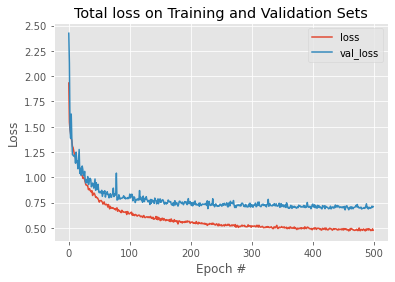

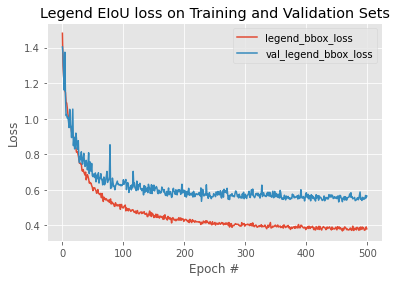

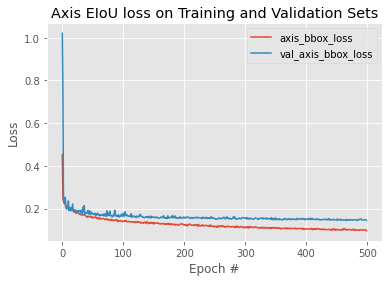

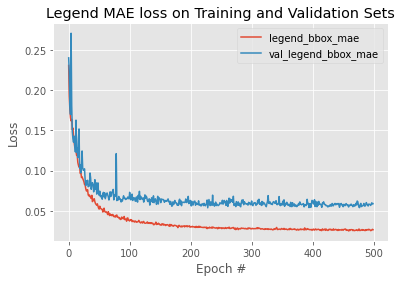

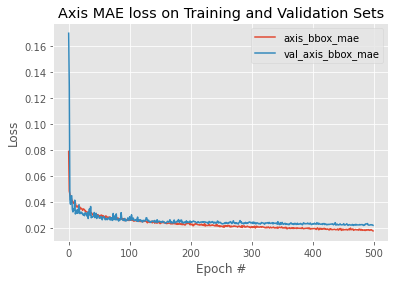

In [ ]:
save_plot('total_loss.png', H, ['loss', 'val_loss'], 'Total loss on Training and Validation Sets')
save_plot('legend_loss.png', H, ['legend_bbox_loss', 'val_legend_bbox_loss'], 'Legend EIoU loss on Training and Validation Sets')
save_plot('axis_loss.png', H, ['axis_bbox_loss', 'val_axis_bbox_loss'], 'Axis EIoU loss on Training and Validation Sets')
#save_plot('num_lines_loss.png', H, ['num_lines_loss', 'val_num_lines_loss'], 'num_lines MAE loss on Training and Validation Sets')

save_plot('legend_mae.png', H, ['legend_bbox_mae', 'val_legend_bbox_mae'], 'Legend MAE loss on Training and Validation Sets')
save_plot('axis_mae.png', H, ['axis_bbox_mae', 'val_axis_bbox_mae'], 'Axis MAE loss on Training and Validation Sets')
# save_plot('num_lines_mae.png', H, ['num_lines_mae', 'val_num_lines_mae'], 'num_lines MAE loss on Training and Validation Sets')

# save_plot('num_lines_accuracy.png', H, ['num_lines_accuracy', 'val_num_lines_accuracy'], 'Accuracy of num lines prediction on Test and Validation sets', loss_plot=False)

PREDICT FILE

predire su training (1) o su validation (2)?: 2
[INFO] loading object detector...
FigureSeerDataset/Annotated_images/01769-10.1.1.182.9583-Figure-6.png
Bbox della legenda attuale: 559 158 659 239
Bbox degli assi attuale: 543 308 88 21
Bbox della legenda predetta: 551 155 662 227
Bbox degli assi predetta: 90 21 527 321


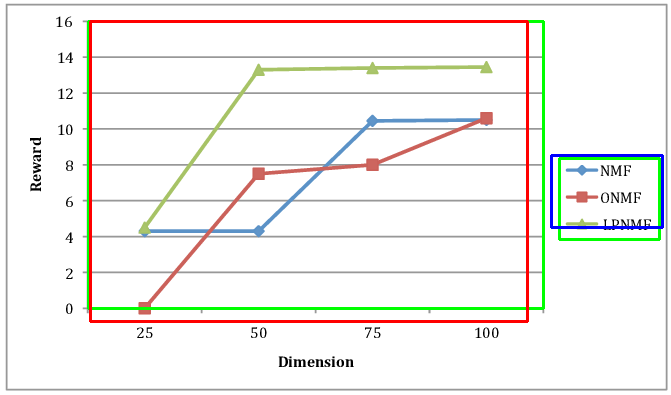

FigureSeerDataset/Annotated_images/00330-10.1.1.15.364-Figure-6.png
Bbox della legenda attuale: 204 344 309 462
Bbox degli assi attuale: 352 474 48 5
Bbox della legenda predetta: 194 348 303 465
Bbox degli assi predetta: 47 9 351 481


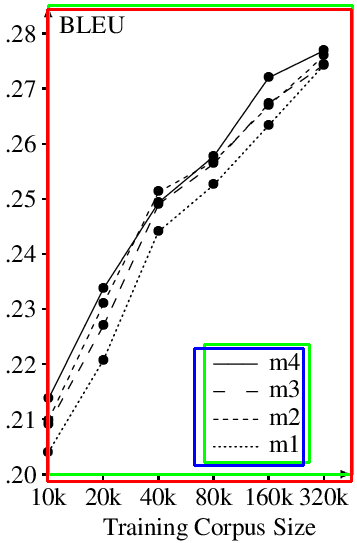

FigureSeerDataset/Annotated_images/02614-10.1.1.231.6389-Figure-9.png
Bbox della legenda attuale: 269 30 550 126
Bbox degli assi attuale: 548 307 39 12
Bbox della legenda predetta: 304 26 542 119
Bbox degli assi predetta: 69 15 547 300


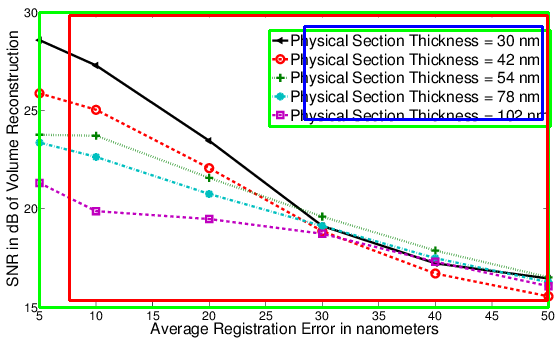

FigureSeerDataset/Annotated_images/01583-10.1.1.112.7020-Figure-22.png
Bbox della legenda attuale: 153 3 614 37
Bbox degli assi attuale: 616 331 111 43
Bbox della legenda predetta: 289 191 585 265
Bbox degli assi predetta: 103 49 604 304


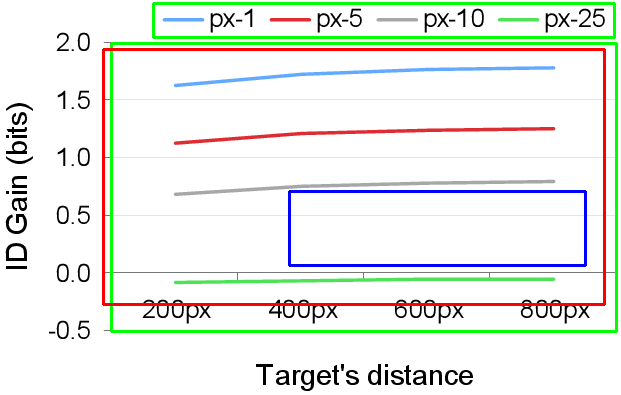

FigureSeerDataset/Annotated_images/02604-10.1.1.164.6302-Figure-8.png
Bbox della legenda attuale: 409 263 589 364
Bbox degli assi attuale: 590 374 90 58
Bbox della legenda predetta: 414 260 590 365
Bbox degli assi predetta: 91 63 584 383


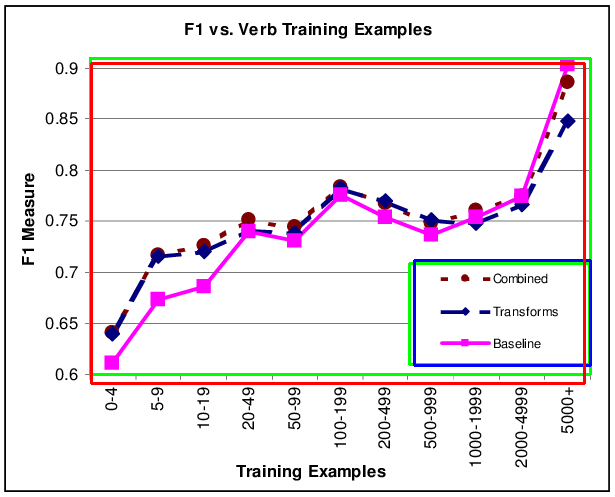

FigureSeerDataset/Annotated_images/02365-10.1.1.15.3037-Figure-1.png
Bbox della legenda attuale: 1011 40 1147 165
Bbox degli assi attuale: 1203 422 117 17
Bbox della legenda predetta: 994 22 1182 114
Bbox degli assi predetta: 128 17 1173 438


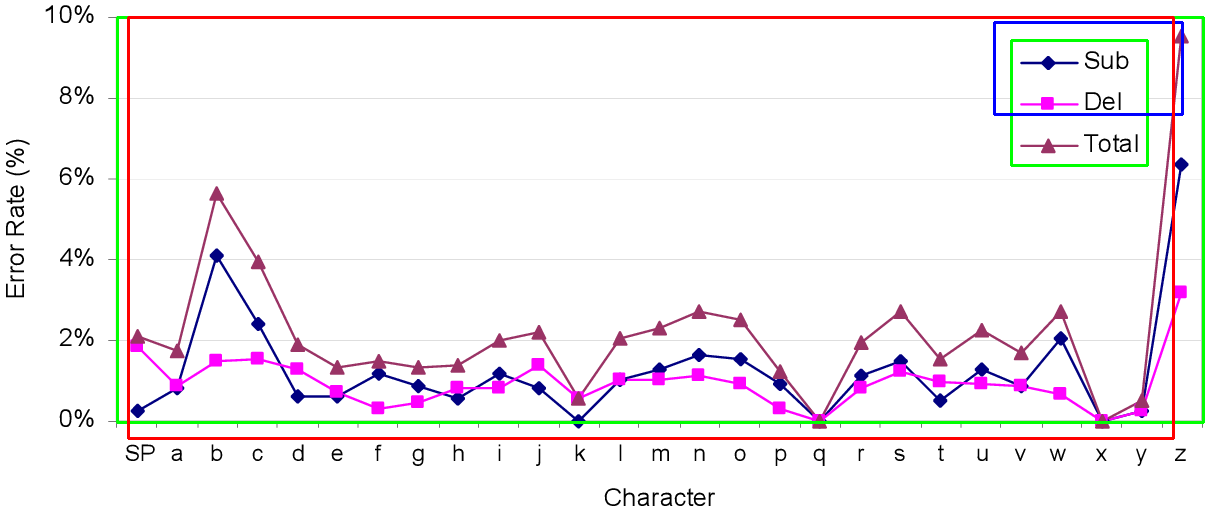

FigureSeerDataset/Annotated_images/01189-10.1.1.39.8052-Figure-4.png
Bbox della legenda attuale: 262 21 571 124
Bbox degli assi attuale: 584 395 90 9
Bbox della legenda predetta: 331 14 581 105
Bbox degli assi predetta: 84 12 589 393


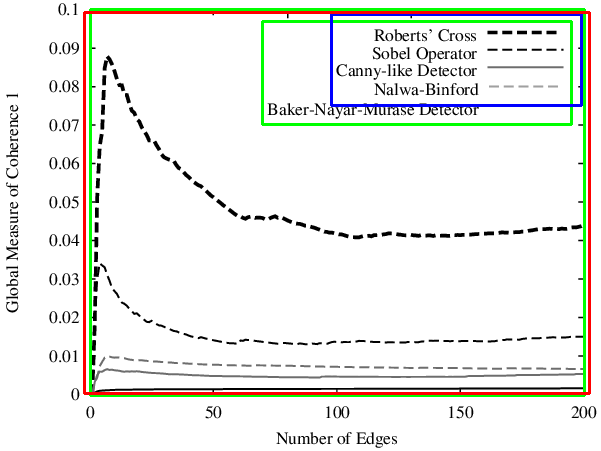

FigureSeerDataset/Annotated_images/01938-10.1.1.378.5484-Figure-1.png
Bbox della legenda attuale: 266 174 497 256
Bbox degli assi attuale: 512 288 61 12
Bbox della legenda predetta: 277 169 514 257
Bbox degli assi predetta: 60 8 523 288


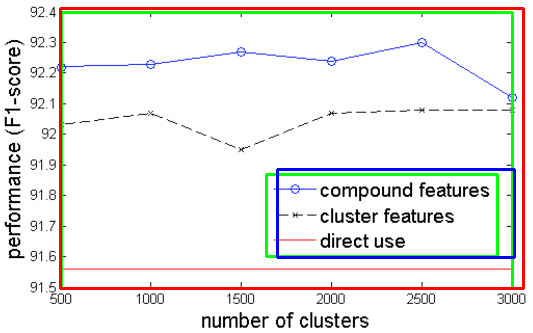

FigureSeerDataset/Annotated_images/02619-10.1.1.30.269-Figure-9.png
Bbox della legenda attuale: 303 28 574 101
Bbox degli assi attuale: 573 202 85 12
Bbox della legenda predetta: 304 18 559 107
Bbox degli assi predetta: 86 9 574 226


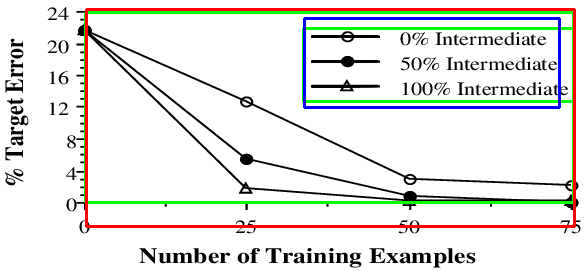

FigureSeerDataset/Annotated_images/01678-10.1.1.149.8317-Figure-4.png
Bbox della legenda attuale: 105 271 260 333
Bbox degli assi attuale: 539 339 101 13
Bbox della legenda predetta: 165 195 339 253
Bbox degli assi predetta: 105 28 526 333


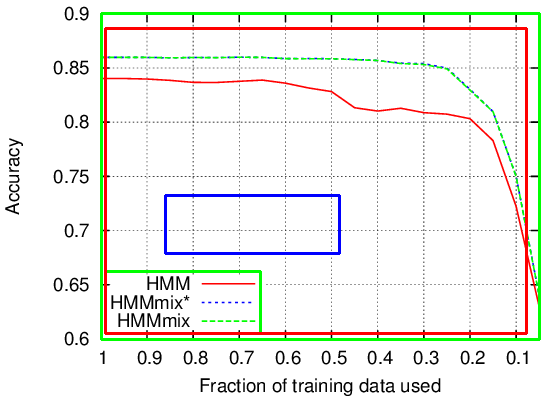

FigureSeerDataset/Annotated_images/01414-10.1.1.129.7259-Figure-7.png
Bbox della legenda attuale: 260 306 567 350
Bbox degli assi attuale: 583 357 108 5
Bbox della legenda predetta: 297 287 590 346
Bbox degli assi predetta: 109 9 605 361


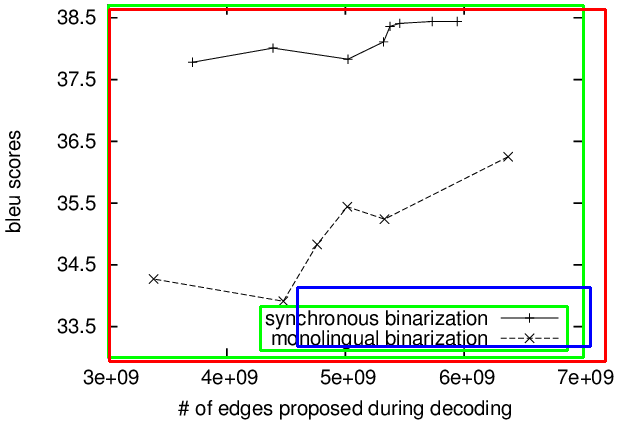

FigureSeerDataset/Annotated_images/00397-10.1.1.165.7670-Figure-8.png
Bbox della legenda attuale: 408 112 462 197
Bbox degli assi attuale: 393 250 82 58
Bbox della legenda predetta: 371 110 465 186
Bbox degli assi predetta: 74 37 364 243


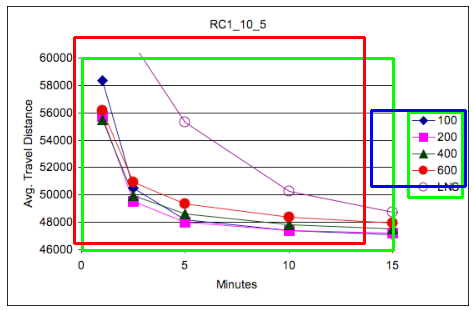

FigureSeerDataset/Annotated_images/02579-10.1.1.2.322-Figure-3.png
Bbox della legenda attuale: 336 18 488 63
Bbox degli assi attuale: 492 363 49 13
Bbox della legenda predetta: 312 13 492 58
Bbox degli assi predetta: 48 8 497 367


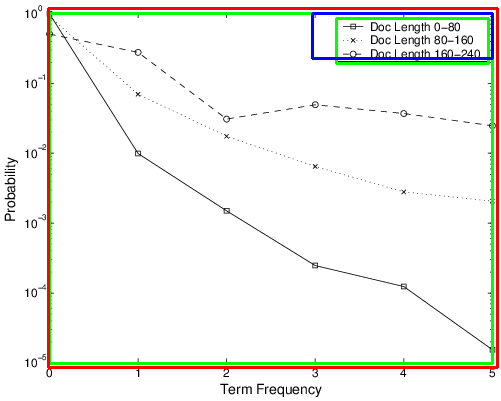

FigureSeerDataset/Annotated_images/01526-10.1.1.187.5344-Figure-6.png
Bbox della legenda attuale: 509 79 661 192
Bbox degli assi attuale: 494 301 80 49
Bbox della legenda predetta: 506 80 663 186
Bbox degli assi predetta: 86 42 487 298


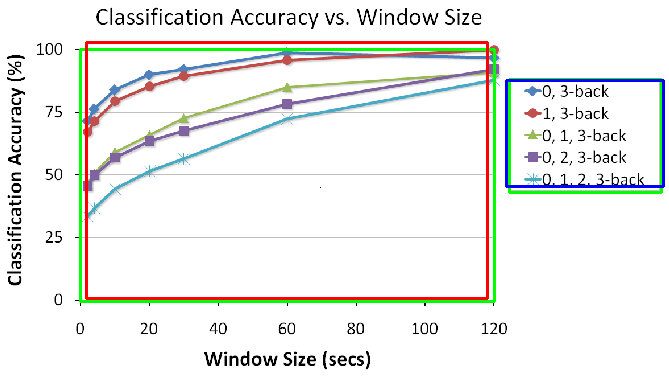

FigureSeerDataset/Annotated_images/00157-10.1.1.386.6332-Figure-7.png
Bbox della legenda attuale: 172 1 397 32
Bbox degli assi attuale: 567 274 53 48
Bbox della legenda predetta: 199 66 356 108
Bbox degli assi predetta: 81 35 555 276


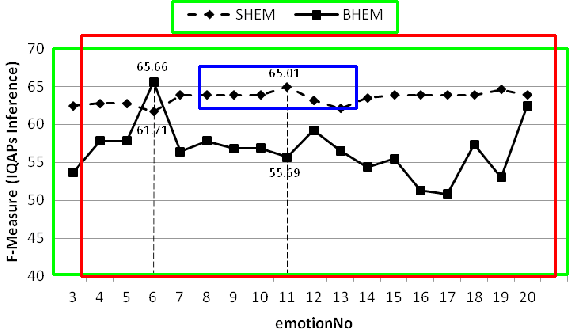

FigureSeerDataset/Annotated_images/01330-10.1.1.153.4833-Figure-8.png
Bbox della legenda attuale: 448 229 580 383
Bbox degli assi attuale: 597 438 82 438
Bbox della legenda predetta: 443 217 586 382
Bbox degli assi predetta: 70 29 593 438


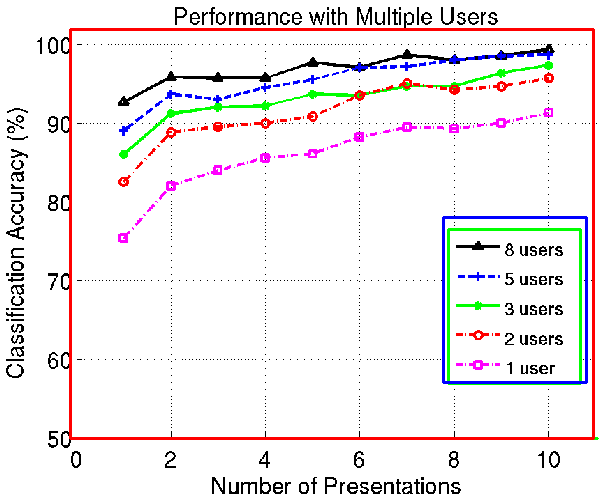

FigureSeerDataset/Annotated_images/00152-10.1.1.178.9802-Figure-3.png
Bbox della legenda attuale: 104 16 260 82
Bbox degli assi attuale: 423 252 99 14
Bbox della legenda predetta: 156 13 353 82
Bbox degli assi predetta: 95 13 426 267


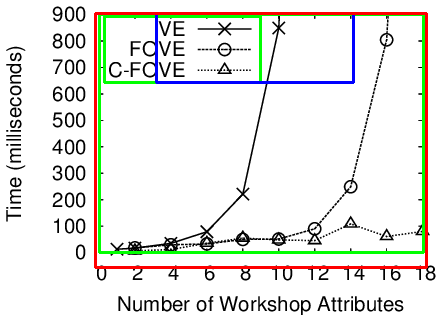

FigureSeerDataset/Annotated_images/02723-10.1.1.48.7461-Figure-5.png
Bbox della legenda attuale: 151 54 357 100
Bbox degli assi attuale: 579 395 93 13
Bbox della legenda predetta: 157 54 357 99
Bbox degli assi predetta: 92 21 579 398


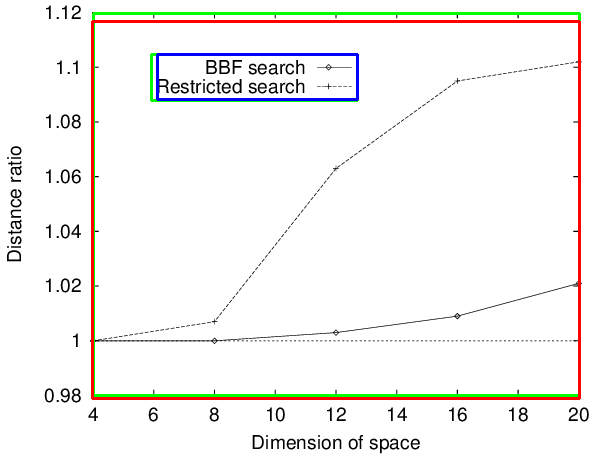

In [ ]:
# import the necessary packages
# import config
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
# import tensorflow_addons as tfa
import numpy as np
import mimetypes
import argparse
import imutils
import cv2
import os
from google.colab.patches import cv2_imshow

# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--input", required=True,
#                 help="path to input image/text file of image filenames")
# args = vars(ap.parse_args())

# # determine the input file type, but assume that we're working with
# # single input image
# filetype = mimetypes.guess_type(args["input"])[0]
# imagePaths = [args["input"]]
# if the file type is a text file, then we need to process *multiple*
# images

switch = input("predire su training (1) o su validation (2)?: ")
if switch == str(1):
    args = 'output/train_images.txt'
else:
    args = 'output/test_images.txt'

filetype = 'text/plain'
imagePaths = [args]
annotsPaths = []

if "text/plain" == filetype:
    # load the filenames in our testing file and initialize our list
    # of image paths
    filenames = open(args).read().strip().split("\n")
    imagePaths = []
    # loop over the filenames
    for f in filenames:
        for row in rows:
            row = row.split(",")
            if f == row[0]:
                annotsPaths.append(row[1:])
        # construct the full path to the image filename and then
        # update our image paths list
        p = os.path.sep.join([IMAGES_PATH, f])
        imagePaths.append(p)

# load our trained bounding box regressor from disk
print("[INFO] loading object detector...")
model = load_model(MODEL_PATH, compile=False)
# loop over the images that we'll be testing using our bounding box
# regression model
i = 0
while i < int(len(imagePaths) / 10):
    # load the input image (in Keras format) from disk and preprocess
    # it, scaling the pixel intensities to the range [0, 1]
    print(imagePaths[i])
    image = load_img(imagePaths[i], target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    # make bounding box predictions on the input image
    preds, axis_preds = model.predict(image)

    (startX, startY, endX, endY) = preds[0]
    (a_startX, a_startY, a_endX, a_endY) = axis_preds[0]

    # load the input image (in OpenCV format), resize it such that it
    # fits on our screen, and grab its dimensions
    image = cv2.imread(imagePaths[i])
    # image = imutils.resize(image, width=600)
    (h, w) = image.shape[:2]
    # scale the predicted bounding box coordinates based on the image
    # dimensions

    if annotsPaths:
        annots = []
        for annot in annotsPaths[i]:
            annots.append(int(annot))
        (gt_l_startX, gt_l_startY, gt_l_endX, gt_l_endY, gt_a_startX, gt_a_startY, gt_a_endX, gt_a_endY, gt_num_lines) = annots

        # print('numero di linee attuale: ' + str(gt_num_lines))
        print('Bbox della legenda attuale: ' + str(gt_l_startX), str(gt_l_startY), str(gt_l_endX), str(gt_l_endY))

        print('Bbox degli assi attuale: ' + str(gt_a_endX), str(gt_a_endY), str(gt_a_startX), str(gt_a_startY))
        # draw the predicted bounding box on the image
        cv2.rectangle(image, (gt_l_startX, gt_l_startY), (gt_l_endX, gt_l_endY), (0, 255, 0), 2)
        cv2.rectangle(image, (gt_a_startX, gt_a_startY), (gt_a_endX, gt_a_endY), (0, 255, 0), 2)

    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)
    print('Bbox della legenda predetta: ' + str(startX), str(startY), str(endX), str(endY))
    a_startX = int(a_startX * w)
    a_startY = int(a_startY * h)
    a_endX = int(a_endX * w)
    a_endY = int(a_endY * h)
    print('Bbox degli assi predetta: ' + str(a_startX), str(a_startY), str(a_endX), str(a_endY))
    # draw the predicted bounding box on the image
    cv2.rectangle(image, (startX, startY), (endX, endY),
                  (255, 0, 0), 2)
    cv2.rectangle(image, (a_startX, a_startY), (a_endX, a_endY),
                  (0, 0, 255), 2)
    # show the output image
    cv2_imshow(image)
    k = cv2.waitKeyEx(0)

    if k == 27:  # close on ESC key
        break
    if k == 2424832:  # get back on left arrow key
        i = i - 1
    else:
        i += 1


In [ ]:
!zip -r output.zip output/

  adding: output/ (stored 0%)
  adding: output/Plots/ (stored 0%)
  adding: output/Plots/total_loss.png (deflated 5%)
  adding: output/Plots/axis_loss.png (deflated 6%)
  adding: output/Plots/axis_mae.png (deflated 6%)
  adding: output/Plots/legend_mae.png (deflated 5%)
  adding: output/Plots/legend_loss.png (deflated 4%)
  adding: output/logs/ (stored 0%)
  adding: output/logs/fit/ (stored 0%)
  adding: output/logs/fit/20210512-152821/ (stored 0%)
  adding: output/logs/fit/20210512-152821/train/ (stored 0%)
  adding: output/logs/fit/20210512-152821/train/events.out.tfevents.1620833339.1fb674e86754.profile-empty (deflated 5%)
  adding: output/logs/fit/20210512-152821/train/plugins/ (stored 0%)
  adding: output/logs/fit/20210512-152821/train/plugins/profile/ (stored 0%)
  adding: output/logs/fit/20210512-152821/train/plugins/profile/2021_05_12_15_28_59/ (stored 0%)
  adding: output/logs/fit/20210512-152821/train/plugins/profile/2021_05_12_15_28_59/1fb674e86754.tensorflow_stats.pb (defla

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir output/logs/fit